In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import requests

from bs4 import BeautifulSoup
import QuantLib as ql

In [92]:
def get_date():
    headers = {'User-Agent': 'Mozilla/5.0'}
    req = requests.get('https://www.wsj.com/market-data/bonds', headers=headers)
    html = req.text
    soup = BeautifulSoup(html, 'html.parser')
    data = soup.find("span", class_ = "WSJBase--card__timestamp--3F2HxyAE")
    
    # JS path
    # document.querySelector("#root > div > div > div > div:nth-child(2) > div.style--grid--SxS2So51 > div > div:nth-child(2) > h3 > span.WSJBase--card__timestamp--3F2HxyAE > span")

    date = data.text
    date = datetime.datetime.strptime(date, "%m/%d/%y").date()
    return date


In [95]:
def get_quote(reference_date):
    tenors = ['01M', '03M', '06M', '01Y', '02Y', '03Y','05Y','07Y','10Y','30Y']

    # create empty lists
    maturities = []
    days = []
    prices = []
    coupons = []
    headers = {'User-Agent': 'Mozilla/5.0'}

    # get market informations
    for i, tenor in enumerate(tenors):
        url = "https://www.wsj.com/market-data/quotes/bond/BX/TMUBMUSD"+tenor+"?mod=md_bond_overview_quote"
        req = requests.get(url, headers=headers)
        html = req.text
        soup = BeautifulSoup(html, 'html.parser')

        # Price 
        data_src = soup.find("span", id="quote_val") 
        price = data_src.text
        price = float(price[:-1])
    
        data_src2 = soup.find_all("span", class_="data_data")

        # Coupon
        coupon = data_src2[2].text
        if coupon != '':
            coupon = float(coupon[:-1])
        else:
            coupon = 0.0
        
        # Maturity Date
        maturity = data_src2[3].text
        maturity = datetime.datetime.strptime(maturity, '%m/%d/%y').date()

        # Send to lists
        days.append((maturity - reference_date).days)
        prices.append(price)
        coupons.append(coupon)
        maturities.append(maturity)
    
    # create dataframe
    df = pd.DataFrame([maturities, days, prices, coupons]).transpose()
    headers = ['maturity', 'days', 'price', 'coupon']
    df.columns = headers
    df.set_index('maturity', inplace=True)

    return df


In [96]:
ref_date = get_date()
quote = get_quote(ref_date)
print(quote)

             days  price coupon
maturity                       
2022-07-12     28  1.125    0.0
2022-09-15     93   1.75    0.0
2022-12-15    184  2.337    0.0
2023-05-18    338  3.161    0.0
2024-05-31    717  3.369    2.5
2025-06-15   1097  3.512  2.875
2027-05-31   1812   3.52  2.625
2029-05-31   2543  3.509   2.75
2032-05-15   3623  3.418  2.875
2052-05-15  10928  3.389  2.875


In [97]:
def treasury_curve(date, quote):
    # divide quote
    # quantlib has differet ways of treating coupon paying and zero coupon bonds
    tbill = quote[0:4]
    tbond = quote[4:]

    # Set evaluation date
    eval_date = ql.Date(date.day, date.month, date.year)
    ql.Settings.instance().evaluationDate = eval_date

    # set market convertions
    calendar = ql.UnitedStates()
    convention = ql.ModifiedFollowing
    day_counter = ql.ActualActual()
    end_of_month = True
    fixing_days = 1
    face_amount = 100
    coupon_frequency = ql.Period(ql.Semiannual)

    # deposit rate helper
    # construct treasury bill(zero coupon) helpers --> DepositRateHelper
    bill_helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(r/100.0)),
                                        ql.Period(m, ql.Days),
                                        fixing_days,
                                        calendar,
                                        convention,
                                        end_of_month,
                                        day_counter)
                    for r, m in zip(tbill['price'], tbill['days'])
                    ]
    
    # construct treasury bond (coupon) helpers --> FixedRateBondHelper
    # additional argument required compared to zero coupon bond
    # we need schedule data to valuate coupon
    bond_helper = []
    for p, c, m in zip(tbond['price'], tbond['coupon'], tbond['days']):
        termination_date = eval_date + ql.Period(m, ql.Days)
        schedule = ql.Schedule(eval_date,
                                termination_date,
                                coupon_frequency,
                                calendar,
                                convention,
                                convention,
                                ql.DateGeneration.Backward,
                                end_of_month
                                )
        bond_helper = ql.FixedRateBondHelper(ql.QuoteHandle(ql.SimpleQuote(p))
                                            fixing_days,
                                            face_amont,
                                            schedule,
                                            [c/100.0],
                                            day_counter,
                                            convention
                                            )
        bond_helper.append(bond_helper)

        # bind helpers
        rate_helpers = bill_helpers + bond_helper

        # Build Curve
        # Use linear interpolation method (The most simple)
        yc_linezero = ql.PiecewiseLinearZero(eval_date, rate_helpers, day_counter)

        return yc_linezero

In [99]:
def discount_factor(date, curve):
    # returns discount factors of each day
    # use quantlib date type
    date = ql.Date(date.day, date.month, date.year)
    return curve.discount(date)

In [100]:
def zero_rate(date, curve):
    date = ql.Date(date.day, date.month, date.year)
    day_counter = ql.ActualActual()
    compounding = ql.Compounded
    freq = ql.Continuous
    zero_rate = curve.zeroRate(date, day_counter, compounding, freq).rate()
    return zero_rate

In [102]:
ref_date = get_date()
quote =get_quote(ref_date)
curve = treasury_curve(ref_date, quote)

In [103]:
quote['discount factor'] = np.nan
quote['zero rate'] = np.nan

for date in quote.index:
    quote.loc[date, 'discount factor'] = discount_factor(date, curve)
    quote.loc[date, 'zero rate'] = zero_rate(date, curve)

print(quote[['discount factor', 'zero rate']])

AttributeError: 'NoneType' object has no attribute 'discount'

KeyError: ('discount factor', 'r.-')

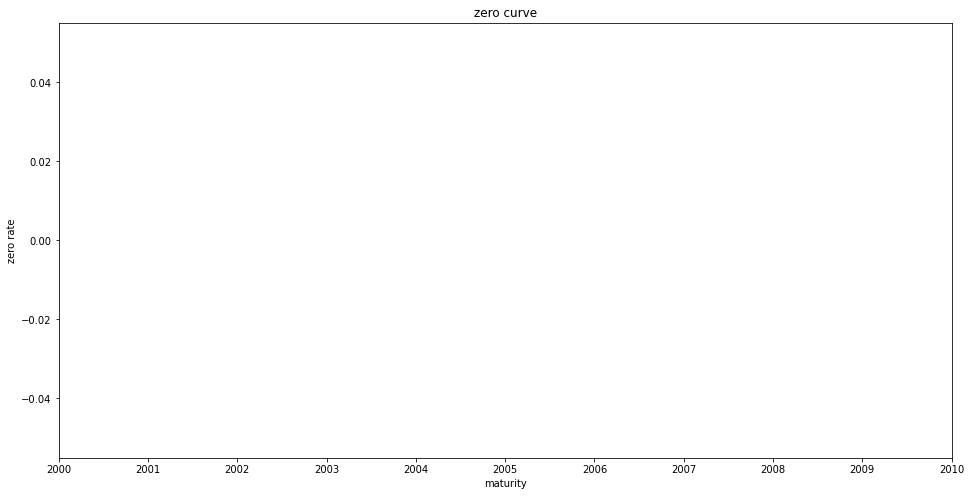

<Figure size 1152x576 with 0 Axes>

In [106]:
plt.figure(figsize=(16,8))
plt.plot(quote['zero rate'], 'b-')
plt.title('zero curve', loc='center')
plt.xlabel('maturity')
plt.ylabel('zero rate')

plt.figure(figsize=(16,8))
plt.plot(quote['discount factor', 'r.-'])
plt.title('discount curve', loc='center')
plt.xlabel('maturity')
plt.ylabel('discount factor')